## Step 1: Fetching Data from the website using web scraping

In [1]:
#import packages needed for scraping..
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
# Mapping of state codes from html code by inspecting the website to state names
state_codes = {
    'U01': 'Andaman & Nicobar Islands',
    'S01': 'Andhra Pradesh',
    'S02': 'Arunachal Pradesh',
    'S03': 'Assam',
    'S04': 'Bihar',
    'U02': 'Chandigarh',
    'S26': 'Chhattisgarh',
    'U03': 'Dadra & Nagar Haveli and Daman & Diu',
    'S05': 'Goa',
    'S06': 'Gujarat',
    'S07': 'Haryana',
    'S08': 'Himachal Pradesh',
    'U08': 'Jammu and Kashmir',
    'S27': 'Jharkhand',
    'S10': 'Karnataka',
    'S11': 'Kerala',
    'U09': 'Ladakh',
    'U06': 'Lakshadweep',
    'S12': 'Madhya Pradesh',
    'S13': 'Maharashtra',
    'S14': 'Manipur',
    'S15': 'Meghalaya',
    'S16': 'Mizoram',
    'S17': 'Nagaland',
    'U05': 'NCT OF Delhi',
    'S18': 'Odisha',
    'U07': 'Puducherry',
    'S19': 'Punjab',
    'S20': 'Rajasthan',
    'S21': 'Sikkim',
    'S22': 'Tamil Nadu',
    'S29': 'Telangana',
    'S23': 'Tripura',
    'S24': 'Uttar Pradesh',
    'S28': 'Uttarakhand',
    'S25': 'West Bengal'
}

base_url = 'https://results.eci.gov.in/PcResultGenJune2024/partywiseresult-{}.htm'

all_data = []

for code, name in state_codes.items():
    url = base_url.format(code)
    try:
        page = requests.get(url)
        if page.status_code != 200: # this is used whether website allows our request or not
            continue
        
        soup = BeautifulSoup(page.text, 'html.parser')
        table = soup.find('table', {'class': 'table'})
        
        if not table:
            continue
        
        headers = [header.text.strip() for header in table.find_all('th')]
        rows = []
        
        for row in table.find_all('tr')[1:]:  # we are not considering the header 
            cells = row.find_all('td')
            rows.append([cell.text.strip() for cell in cells])
        
        tfoot = table.find('tfoot')
        if tfoot:
            total_row = tfoot.find('tr')
            total_cells = total_row.find_all('th') if total_row else []
            total_data = [cell.text.strip() for cell in total_cells]
            if len(total_data) == len(headers):
                rows.append(total_data)
        
        headers = ['Party', 'Won', 'Leading', 'Total']
        
        df = pd.DataFrame(rows, columns=headers)
        df['State'] = name
        
        all_data.append(df)
        
    except Exception as e:
        print(f"Could not process {name} ({code}): {e}")

# Combining all data into one single dataframew
df_all_states = pd.concat(all_data, ignore_index=True)
df_all_states = df_all_states[['Party', 'Won', 'State', 'Total']] 

## Step 2: Data cleaning and adding new neccessary columns

In [3]:
#Removing all rows which have null values 
df_all_states = df_all_states.dropna(subset=['Party'])


In [4]:
df_all_states.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 130
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Party   96 non-null     object
 1   Won     96 non-null     object
 2   State   96 non-null     object
 3   Total   96 non-null     object
dtypes: object(4)
memory usage: 3.8+ KB


In [12]:
# Changing Won and Total datatype to integer 
df_all_states['Won'] = pd.to_numeric(df_all_states['Won'], errors='coerce')
df_all_states['Total'] = pd.to_numeric(df_all_states['Total'], errors='coerce')
df_all_states.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 0 to 130
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Party                  96 non-null     object 
 1   Won                    96 non-null     int64  
 2   State                  96 non-null     object 
 3   Total                  96 non-null     int64  
 4   Party_Type             96 non-null     object 
 5   Seat_Share_Percentage  96 non-null     float64
dtypes: float64(1), int64(2), object(3)
memory usage: 5.2+ KB


In [13]:
#Changing total column to total no. of seats present in that particular state 
df_all_states['Total'] = df_all_states.groupby('State')['Won'].transform('sum')


In [15]:
#Adding Party type column 
national_parties_list = [
    'Bharatiya Janata Party - BJP',
    'Indian National Congress - INC',
    'Communist Party of India (Marxist) - CPI(M)',
    'Aam Aadmi Party - AAP',
    'Bahujan Samaj Party - BSP',
    "National People's Party"
]

def categorize_party(party):
    if party in national_parties_list:
        return 'National'
    else:
        return 'Regional'

df_all_states['Party_Type'] = df_all_states['Party'].apply(categorize_party)


In [ ]:
#Adding seat share percentage column 
#Calculate seat share percentage for each party in each state
df_all_states['Seat_Share_Percentage'] = round((df_all_states['Won'] / df_all_states['Total']) * 100 ,2)
print(df_all_states[['State', 'Party', 'Seat_Share_Percentage']])

## Step 3: Load this data into a CSV file  

In [18]:
#Saving this data into a csv file 
df_all_states.to_csv('Loksabha_results_of_all_states.csv', index=False)


In [19]:
print(df_all_states)

                                             Party  Won  \
0                     Bharatiya Janata Party - BJP    1   
2                               Telugu Desam - TDP   16   
3    Yuvajana Sramika Rythu Congress Party - YSRCP    4   
4                     Bharatiya Janata Party - BJP    3   
5                             Janasena Party - JnP    2   
..                                             ...  ...   
124                     Apna Dal (Soneylal) - ADAL    1   
126                   Bharatiya Janata Party - BJP    5   
128            All India Trinamool Congress - AITC   29   
129                   Bharatiya Janata Party - BJP   12   
130                 Indian National Congress - INC    1   

                         State  Total Party_Type  Seat_Share_Percentage  
0    Andaman & Nicobar Islands      1   National                 100.00  
2               Andhra Pradesh     25   Regional                  64.00  
3               Andhra Pradesh     25   Regional                  16.

## Step 4: Insights about the Data

In [23]:
#importing matplotlib and seaborn libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Insight 1: State-Wise Seat Distribution (State: State/Union Territory)

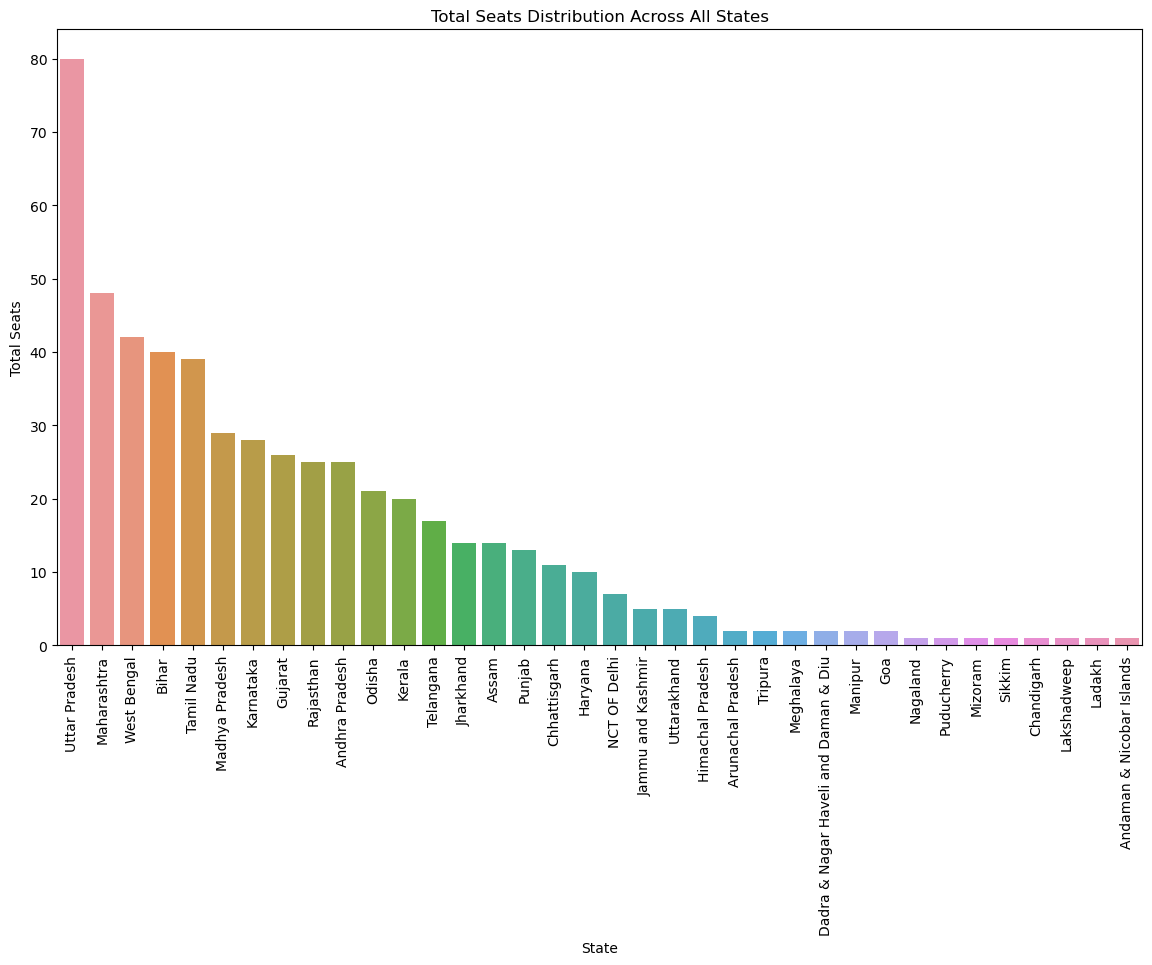

In [24]:
total_seats_distribution = df_all_states[['State', 'Total']].drop_duplicates().sort_values(by='Total', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=total_seats_distribution, x='State', y='Total')
plt.title('Total Seats Distribution Across All States')
plt.xlabel('State')
plt.ylabel('Total Seats')
plt.xticks(rotation=90)
plt.show()

#### From this graph we can say that Uttar Pradesh has most number of seats in Lok Sabha

### Insight 2: Top 10 winning parties in this elections 

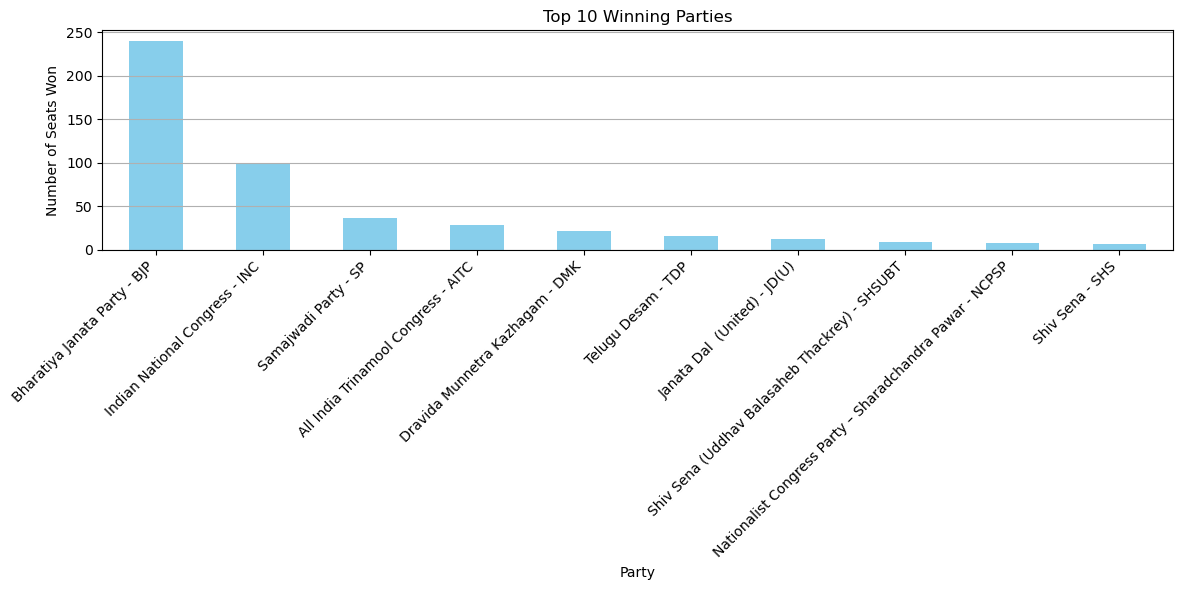

In [25]:
#Top 10 parties
import matplotlib.pyplot as plt

# Top Winning Parties
top_winning_parties = df_all_states.groupby('Party')['Won'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_winning_parties.plot(kind='bar', color='skyblue')
plt.title('Top 10 Winning Parties')
plt.xlabel('Party')
plt.ylabel('Number of Seats Won')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

#### From This Insight we can say that Bharatiya Janata Party - BJP has secured most number of seats and Indian National Congress is in second place.

### Insight 3: State wise seat distribution with party names

<Figure size 1500x800 with 0 Axes>

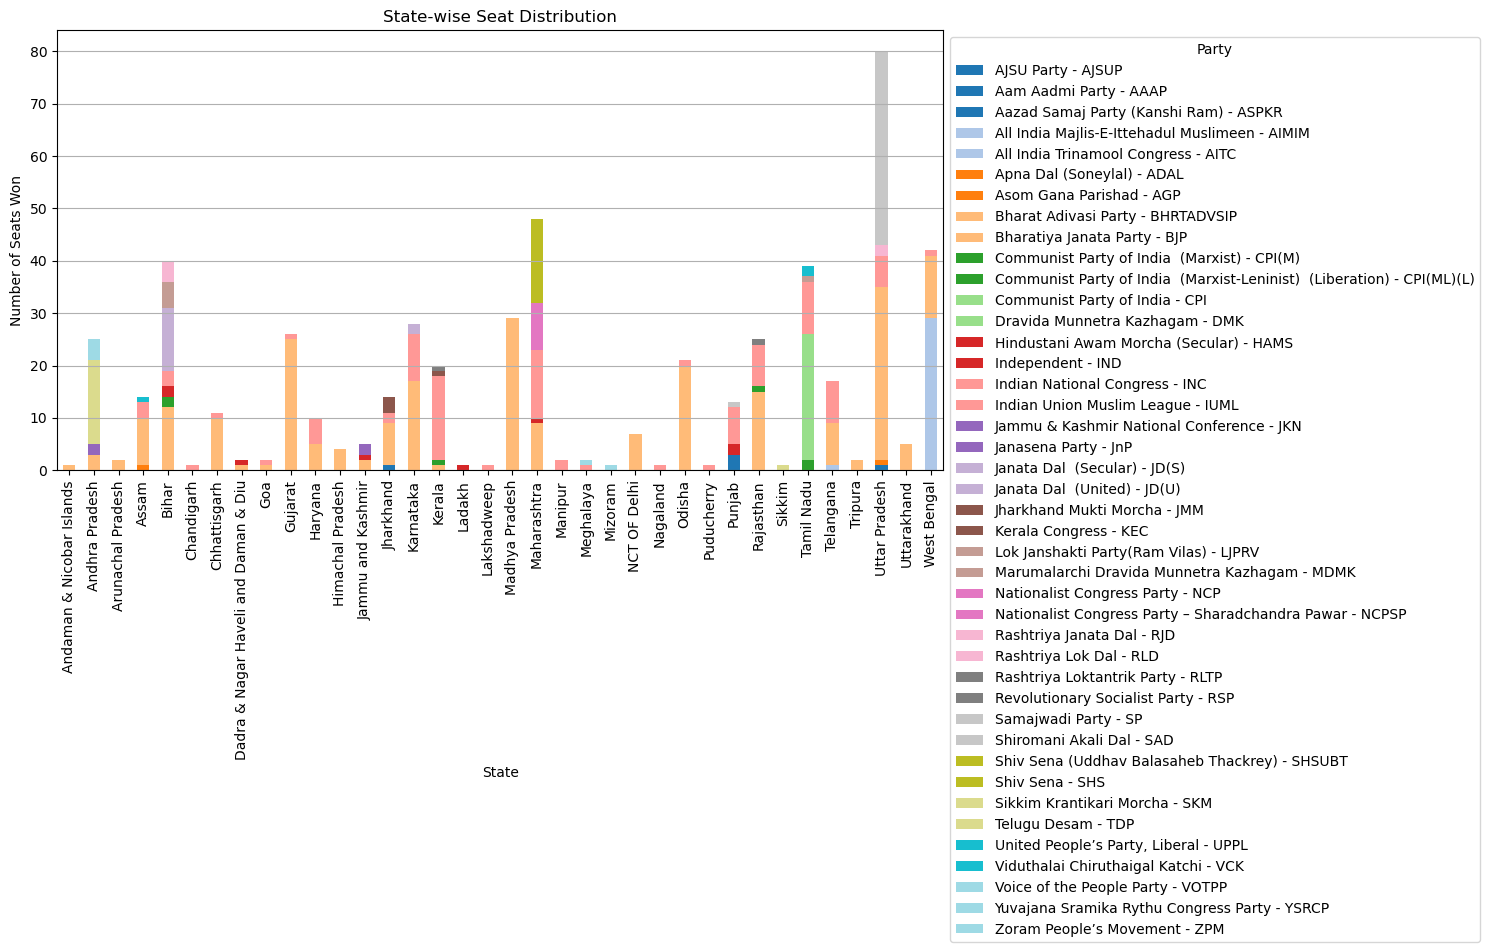

In [26]:
# State-wise Seat Distribution
state_wise_seat_distribution = df_all_states.pivot_table(index='State', columns='Party', values='Won', aggfunc='sum', fill_value=0)

plt.figure(figsize=(15, 8))
state_wise_seat_distribution.plot(kind='bar', stacked=True, figsize=(15, 8), cmap='tab20')
plt.title('State-wise Seat Distribution')
plt.xlabel('State')
plt.ylabel('Number of Seats Won')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Party')
plt.grid(axis='y')

plt.tight_layout()
plt.show()


### Insight 4: Performance of National vs Regional Parties

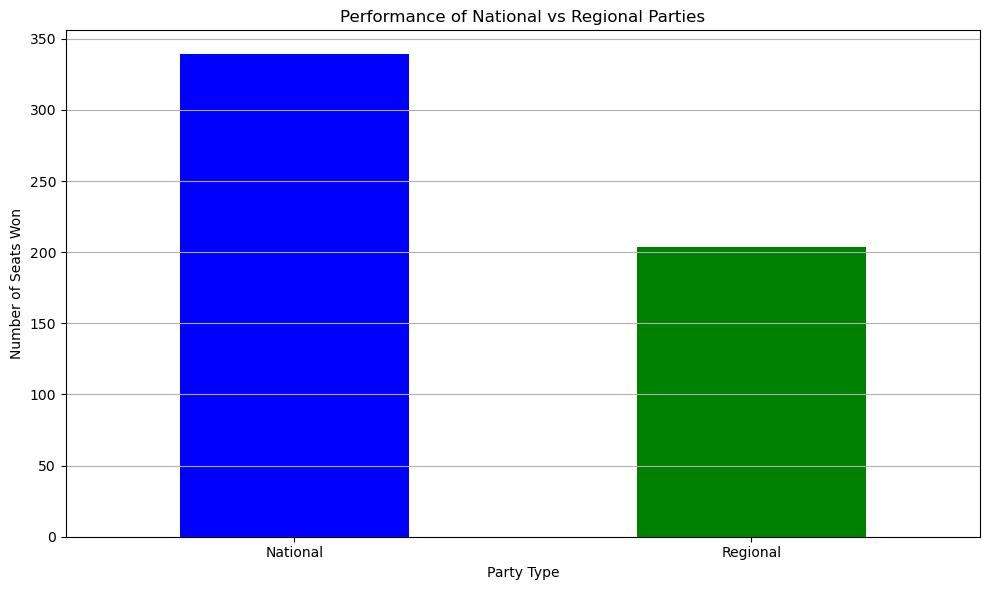

In [27]:
# Performance of National vs Regional Parties
performance_by_type = df_all_states.groupby('Party_Type')['Won'].sum()

# Plotting Performance of National vs Regional Parties
plt.figure(figsize=(10, 6))
performance_by_type.plot(kind='bar', color=['blue', 'green'])
plt.title('Performance of National vs Regional Parties')
plt.xlabel('Party Type')
plt.ylabel('Number of Seats Won')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

#### Majority of the seats are won by National Parties

### Insight 5: Party-wise seat wins over Multiple States

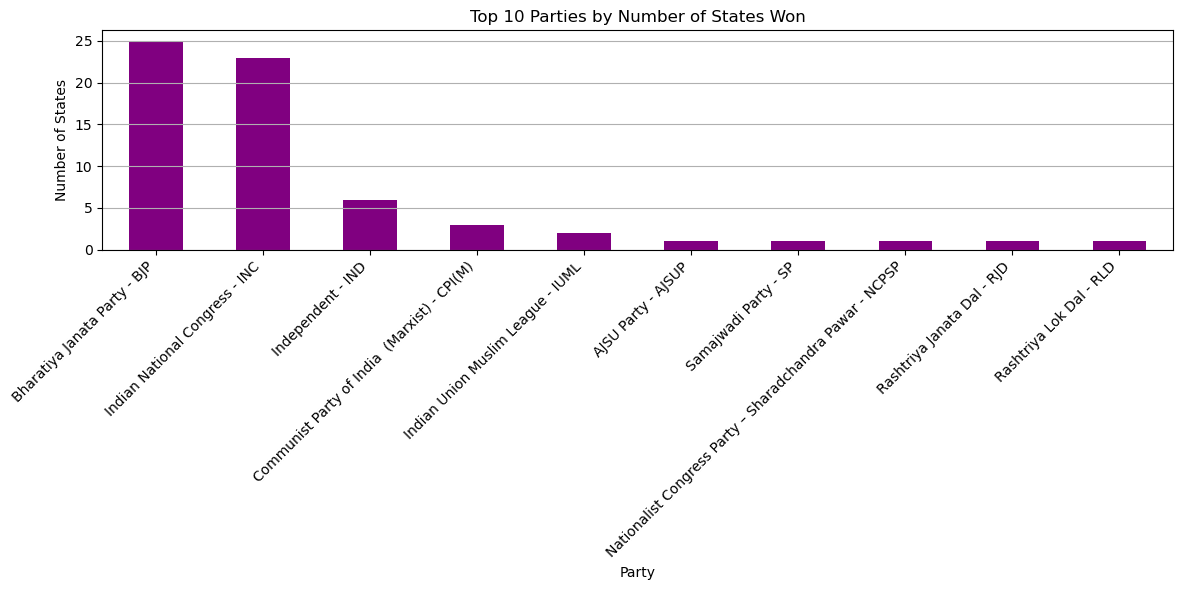

In [28]:
party_wins_ms = df_all_states.groupby('Party')['State'].nunique().sort_values(ascending=False).head(10)

# Plotting Party-wise Seat Wins over Multiple States
plt.figure(figsize=(12, 6))
party_wins_ms.plot(kind='bar', color='purple')
plt.title('Top 10 Parties by Number of States Won')
plt.xlabel('Party')
plt.ylabel('Number of States')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

#### BJP has won seats in 25 States/UT 

### Insight 6: Performance of Parties in Major States

<Figure size 1500x800 with 0 Axes>

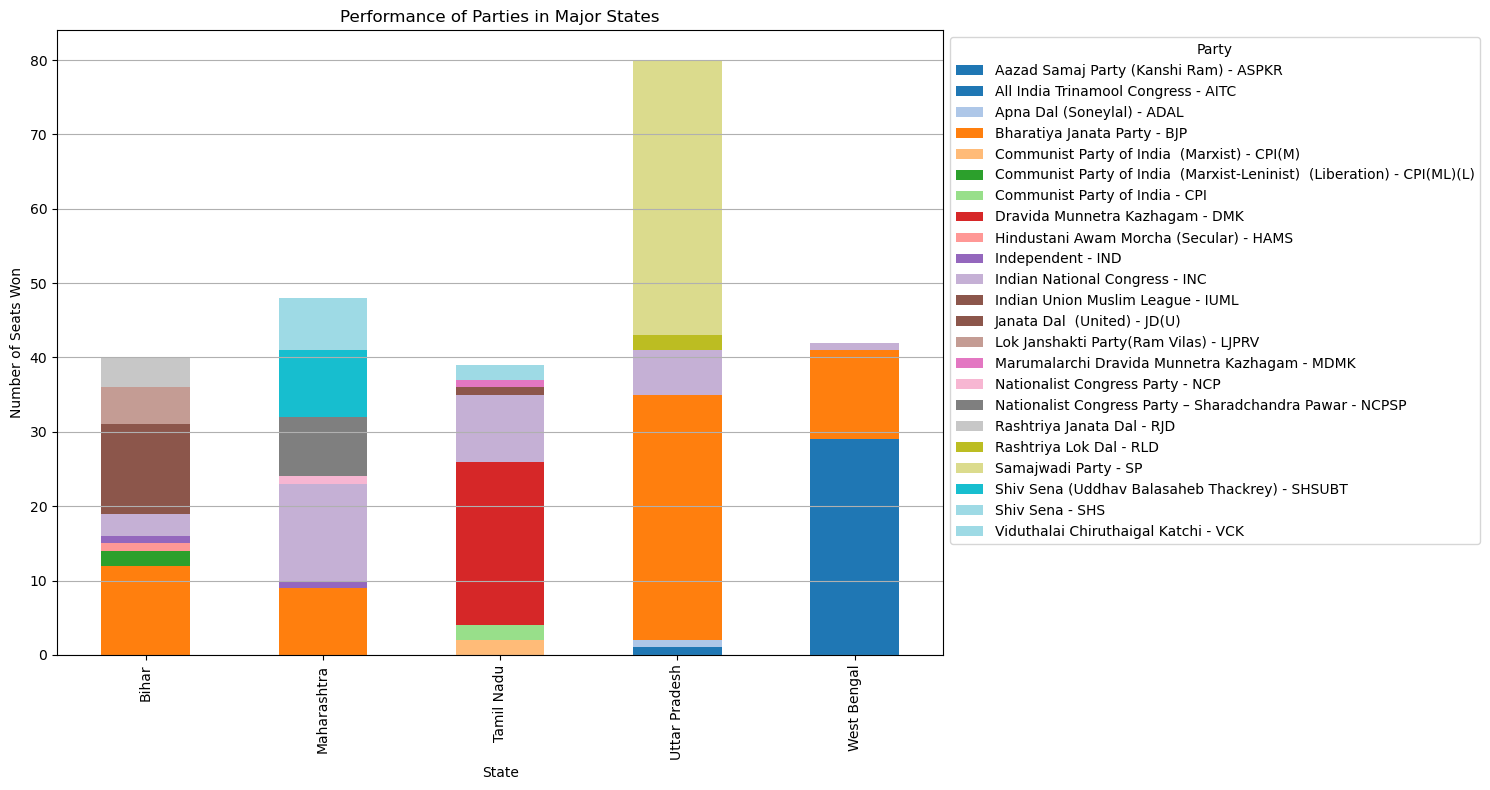

In [30]:
#Top 5 states with the highest total seats
major_states = df_all_states.groupby('State')['Total'].max().sort_values(ascending=False).head(5).index

#Performance of Parties in Major States
performance_major_states = df_all_states[df_all_states['State'].isin(major_states)]

plt.figure(figsize=(15, 8))
performance_major_states.pivot_table(index='State', columns='Party', values='Won', aggfunc='sum', fill_value=0).plot(kind='bar', stacked=True, figsize=(15, 8), cmap='tab20')
plt.title('Performance of Parties in Major States')
plt.xlabel('State')
plt.ylabel('Number of Seats Won')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Party')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

#### These are the 5 states which has most number of seats and we can see which party has how much percentage in that particular state

### Insight 7: Average number of Seats Won per state by party

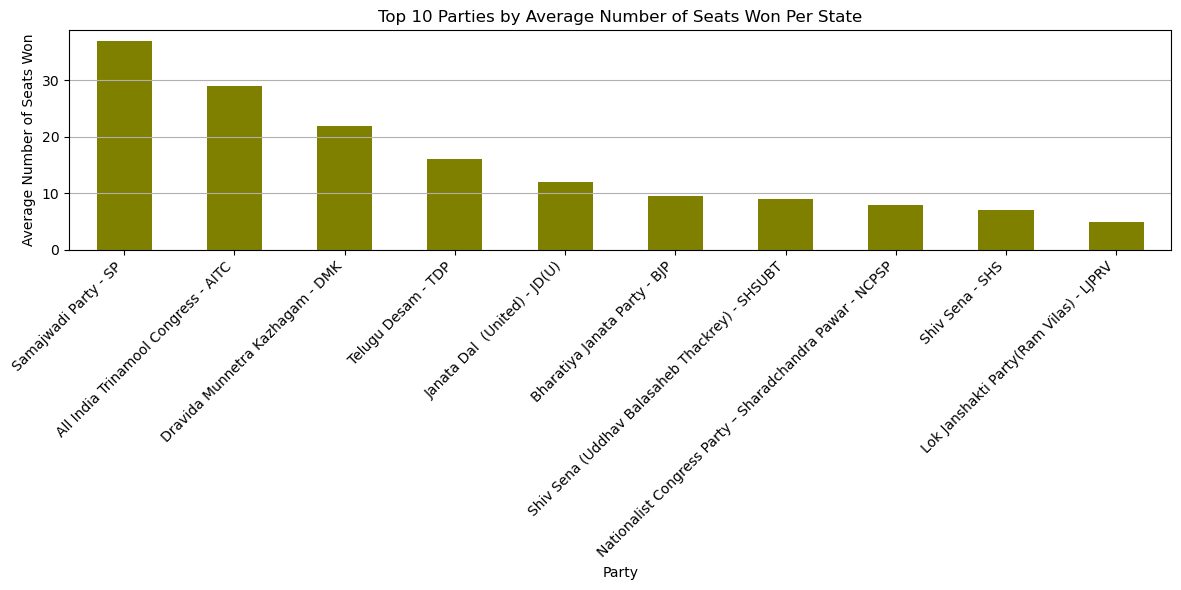

In [31]:
# Average Number of Seats Won Per State by Party
average_seats_won_per_state = df_all_states.groupby('Party')['Won'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
average_seats_won_per_state.plot(kind='bar', color='olive')
plt.title('Top 10 Parties by Average Number of Seats Won Per State')
plt.xlabel('Party')
plt.ylabel('Average Number of Seats Won')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#### Samajwadi Party has the highest average of seats per state

### Insight 8: Distribution Seat share percentage 

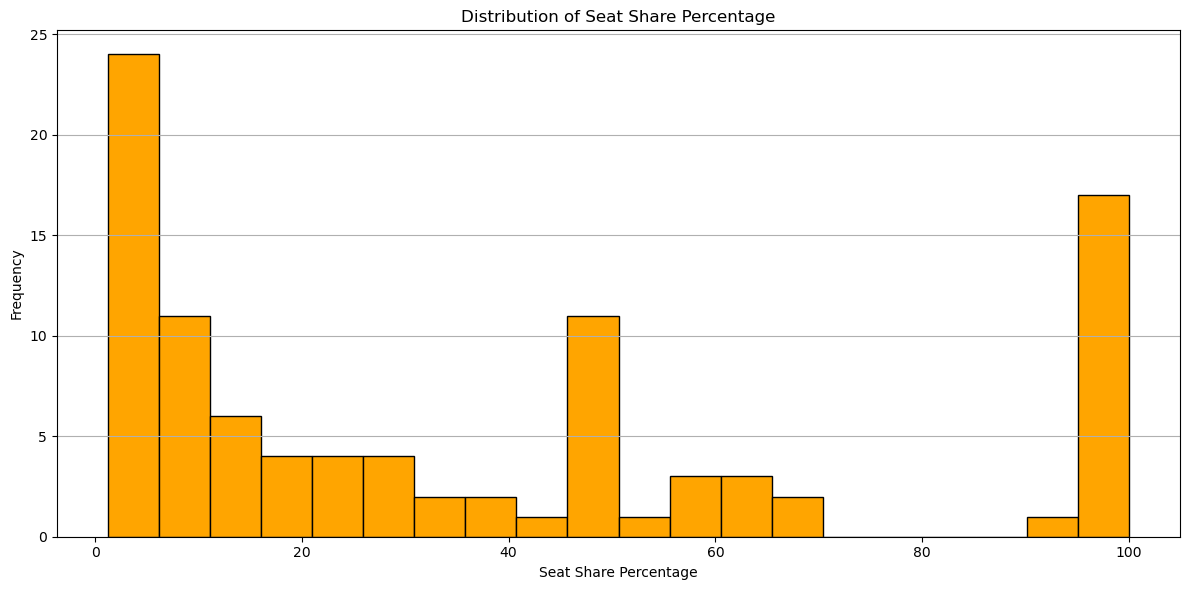

In [32]:
plt.figure(figsize=(12, 6))
df_all_states['Seat_Share_Percentage'].plot(kind='hist', bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Seat Share Percentage')
plt.xlabel('Seat Share Percentage')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### The highest frequency is 24 which means most 24 parties got 5% seat share in their particular state and 17 parties got 100% seat share in particular state/UT

### Insight 9: Swing Seats(Seats Won with < 5% Margin)

In [34]:
#Calculate Margin
df_all_states['Margin'] = df_all_states['Won'] - (df_all_states['Total'] - df_all_states['Won'])

swing_seat_analysis = df_all_states[df_all_states['Margin'] < 5].groupby('Party')['Won'].sum()
print("Analysis of Swing Seats (Seats Won with < 5% Margin):")
print(swing_seat_analysis)


Analysis of Swing Seats (Seats Won with < 5% Margin):
Party
AJSU Party - AJSUP                                                           1
Aam Aadmi Party - AAAP                                                       3
Aazad Samaj Party (Kanshi Ram) - ASPKR                                       1
All India Majlis-E-Ittehadul Muslimeen - AIMIM                               1
Apna Dal (Soneylal) - ADAL                                                   1
Asom Gana Parishad - AGP                                                     1
Bharat Adivasi Party - BHRTADVSIP                                            1
Bharatiya Janata Party - BJP                                               127
Communist Party of India  (Marxist) - CPI(M)                                 4
Communist Party of India  (Marxist-Leninist)  (Liberation) - CPI(ML)(L)      2
Communist Party of India - CPI                                               2
Hindustani Awam Morcha (Secular) - HAMS                                

#### This shows the parties which won with <5% margin 

### Insight 10: Regional Dominance of National Parties

In [36]:
# Identifing states/UT where national parties have won a significant percentage of seats (> 70%)
np_regional_dominance = df_all_states[df_all_states['Party_Type'] == 'National'].groupby('State')['Won'].sum() / df_all_states.groupby('State')['Won'].sum()
print("Regional Dominance of National Parties (Percentage of Seats Won):")
print(np_regional_dominance[np_regional_dominance > 0.7])
print()

Regional Dominance of National Parties (Percentage of Seats Won):
State
Andaman & Nicobar Islands    1.000000
Arunachal Pradesh            1.000000
Assam                        0.857143
Chandigarh                   1.000000
Chhattisgarh                 1.000000
Goa                          1.000000
Gujarat                      1.000000
Haryana                      1.000000
Himachal Pradesh             1.000000
Jharkhand                    0.714286
Karnataka                    0.928571
Kerala                       0.750000
Lakshadweep                  1.000000
Madhya Pradesh               1.000000
Manipur                      1.000000
NCT OF Delhi                 1.000000
Nagaland                     1.000000
Odisha                       1.000000
Puducherry                   1.000000
Rajasthan                    0.880000
Telangana                    0.941176
Tripura                      1.000000
Uttarakhand                  1.000000
Name: Won, dtype: float64



#### In these states/UT National Parties have more majority than regional parties

### So these are some Key insights which are helpul for analyzing the Lok Sabha election results 2024